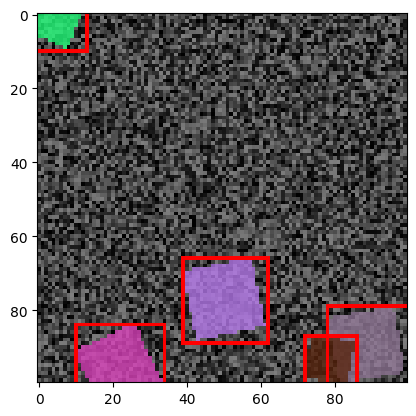

In [1]:
from torch import nn
import torch
import torchvision
import matplotlib.pyplot as plt
from square_data_generator import make_image
from torchvision.utils import draw_bounding_boxes

img, bboxes = make_image((100, 100), 5)
predicted_bboxes = torchvision.ops.box_convert(bboxes, in_fmt="xywh", out_fmt="xyxy")

img_with_boxes = draw_bounding_boxes(
    (img.permute(2, 0, 1) * 255).to(torch.uint8),
    predicted_bboxes,
    colors="red",
    width=1,
)
plt.imshow(img_with_boxes.permute(1, 2, 0))

In [2]:
from square_data_generator import label_sort_big_to_small


def ordered_loss_big_to_small(
    predicted_bboxes: torch.Tensor, target_bboxes: torch.Tensor
) -> torch.Tensor:
    _loss = 0

    for batch_idx in range(predicted_bboxes.size(0)):
        sorted_predicted = label_sort_big_to_small(predicted_bboxes[batch_idx])
        for idx in range(5):
            _loss += nn.functional.mse_loss(
                sorted_predicted[idx], target_bboxes[batch_idx][idx]
            )
            # (x_min - pred_x_min)^2 + ...
    return _loss


In [3]:
# Make a torch nn that takes a (batched) nx100x100x3 image and outputs a 5x4 tensor for each


class BoundingBoxPredictor(nn.Module):
    def __init__(self):
        super(BoundingBoxPredictor, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 20)  # 5 bounding boxes * 4 coordinates each
        self.elu = nn.ELU()

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.max_pool2d(x, 2)
        x = torch.relu(self.conv2(x))
        x = torch.max_pool2d(x, 2)
        x = torch.relu(self.conv3(x))
        x = torch.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.elu(x) + 1  # All values should be positive at the end.
        x = x.view(-1, 5, 4)  # reshape to (batch_size, 5, 4)
        return x

In [ ]:
model = BoundingBoxPredictor()
# Define the optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

EPOCH_PRINT_INTERVAL = 5

# batch the bboxes
batches_bboxes = bboxes.unsqueeze(0)

all_images = []

# Training loop
num_epochs = 300
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    # Forward pass
    predictions = model(img.clone().permute(2, 0, 1).unsqueeze(0))

    # Compute loss
    loss = ordered_loss_big_to_small(
        predictions, torch.tensor(batches_bboxes, dtype=torch.float32)
    )

    # Backward pass and optimization
    loss.backward()
    optimizer.step()

    # Print the loss every 100 epochs
    if (epoch + 1) % 100 == 0:
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}")

    # Print the predicted image with bounding boxes every 10 epochs
    if (epoch + 1) % EPOCH_PRINT_INTERVAL == 0:
        model.eval()
        with torch.no_grad():
            predicted_bboxes = predictions[0].cpu()
            predicted_bboxes = torchvision.ops.box_convert(
                predicted_bboxes, in_fmt="cxcywh", out_fmt="xyxy"
            )

            img_with_boxes = draw_bounding_boxes(
                (img.clone().permute(2, 0, 1) * 255).to(torch.uint8),
                predicted_bboxes,
                colors="red",
                width=2,
            )
            all_images.append(img_with_boxes)

/var/folders/vc/1d1z34l176gfm4swwfttvslr0000gn/T/ipykernel_65553/3761593505.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions, torch.tensor(batches_bboxes, dtype=torch.float32)


Epoch [100/300], Loss: 11.3410
Epoch [200/300], Loss: 11.2500
Epoch [300/300], Loss: 11.2500


In [5]:
print(predicted_bboxes)

tensor([[ 78.0000,  79.0000, 100.0000, 101.0000],
        [  0.0000,   0.0000,  16.0000,  16.0000],
        [ 39.0000,  66.0000,  62.0000,  89.0000],
        [ 72.0000,  87.0000,  86.0000, 101.0000],
        [ 10.0000,  84.0000,  34.0000, 108.0000]])


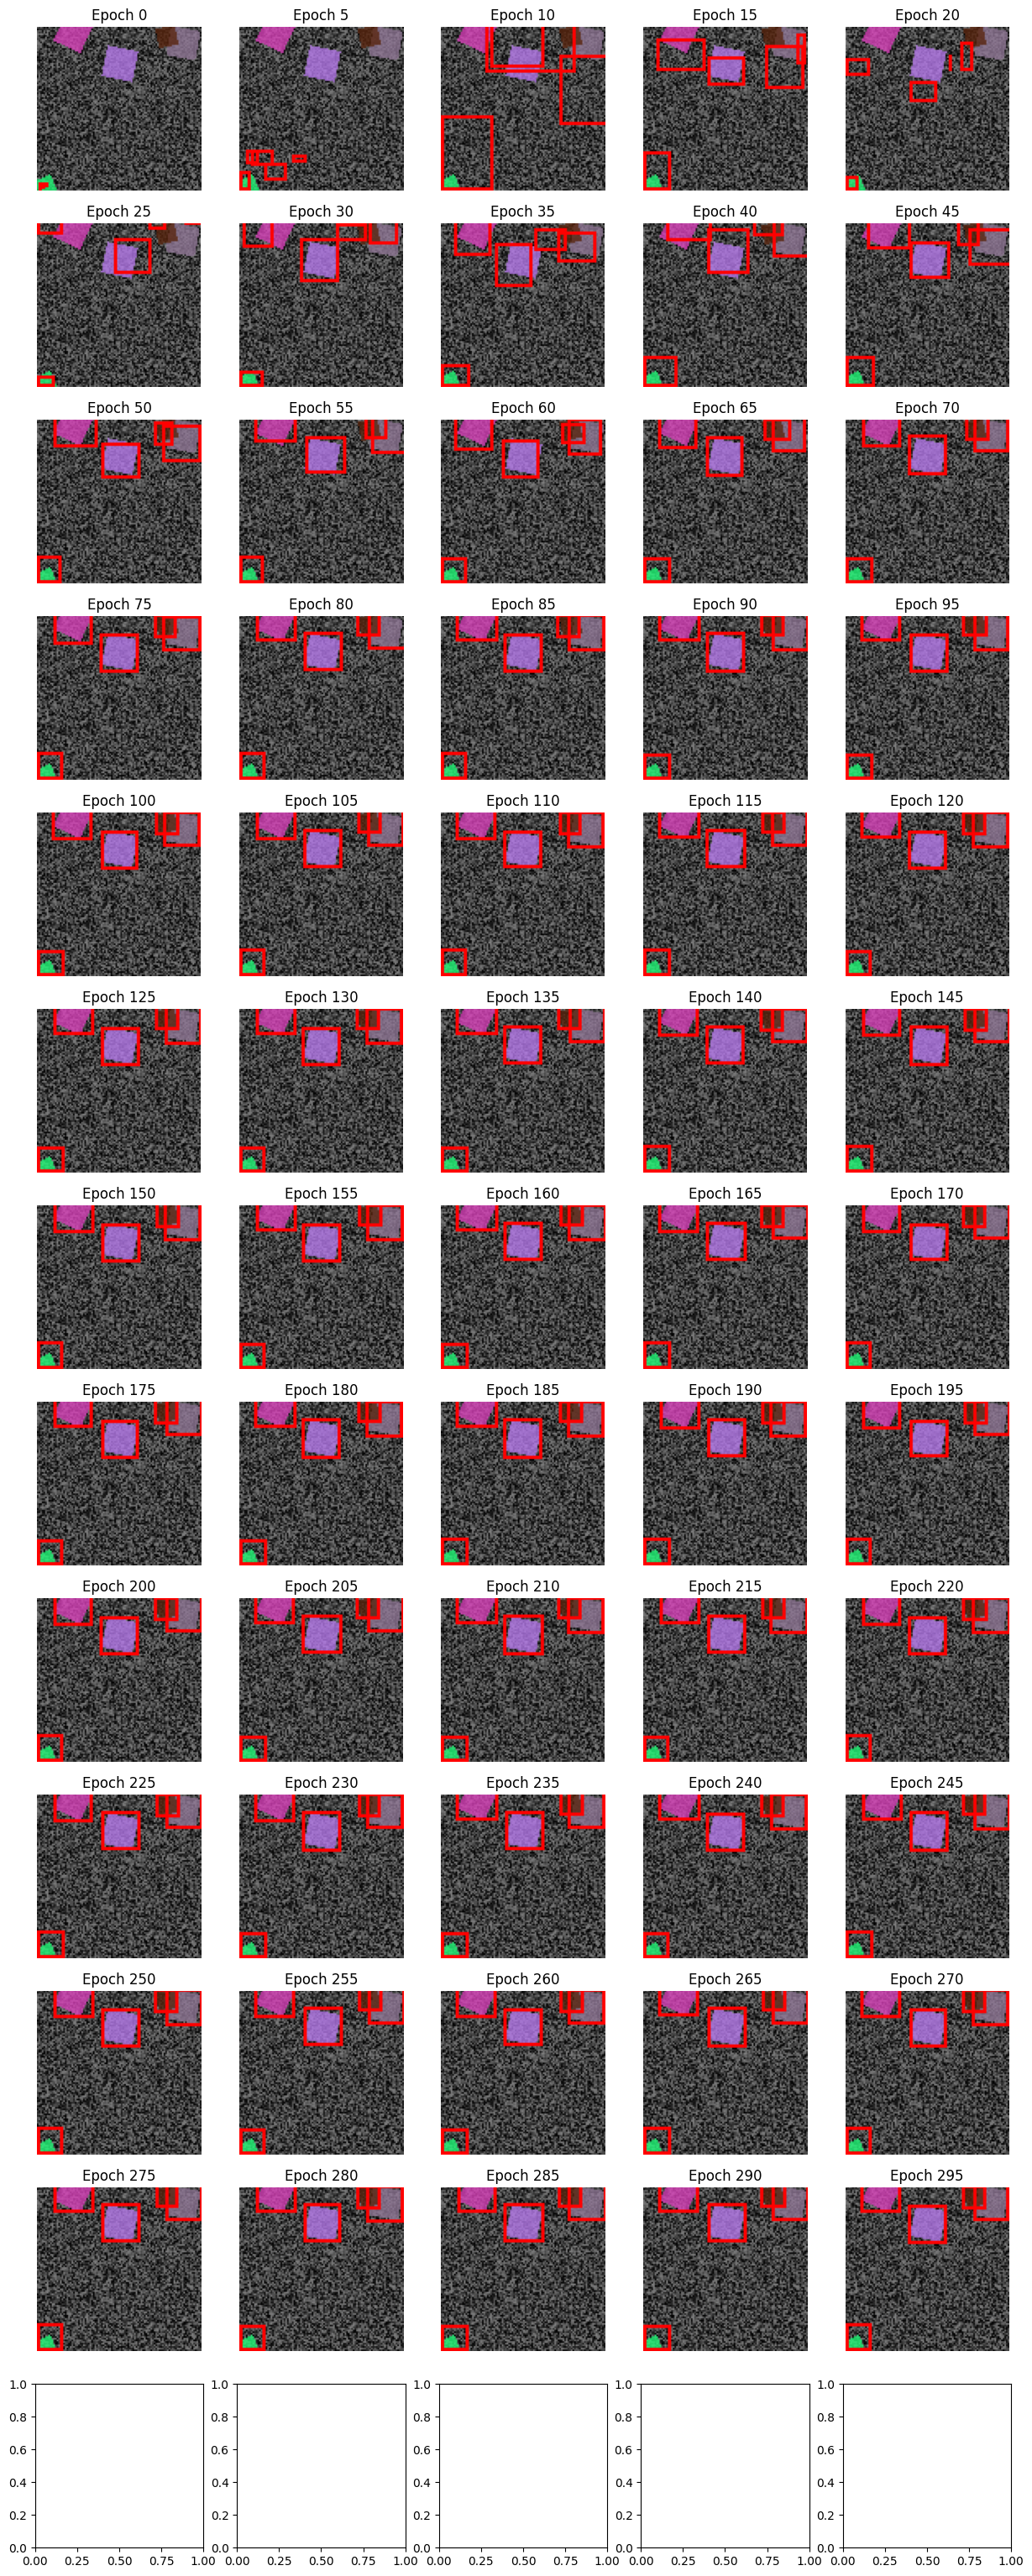

In [6]:
# go through all images and plot them in a img grid
n_images = len(all_images)
n_cols = 5
n_rows = n_images // n_cols + 1
fig, ax = plt.subplots(n_rows, n_cols, figsize=(n_cols * 3, n_rows * 3))
for i in range(n_images):
    this_ax = ax[i // n_cols, i % n_cols]
    this_ax.imshow(all_images[i].permute(1, 2, 0), origin="lower")
    this_ax.axis("off")
    this_ax.set_title(f"Epoch {i * EPOCH_PRINT_INTERVAL}")
plt.show()